In [1]:
import os, subprocess
out = subprocess.run(["uname", "-a"], capture_output=True)
if "Darwin" in str(out.stdout):
    print('overriding PATH')
    os.environ['PATH'] = "/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:" +  os.environ['PATH']

overriding PATH


In [2]:
# Orchestration/Data Extraction function defs

from collections import defaultdict
import re
import os
from pathlib import Path
import subprocess
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib_venn import venn3, venn2

success_column = "Passed"
#success_column = "RejudgementPassed"
#success_column = "ConsensusPassed"


def invert_mapping(dictionary: dict) -> dict:
    return {elem: k for k, v in dictionary.items() for elem in v}

figure_annotations = {
    "child_benefit": {
        "success_rates_by_permutation_model_size.hist": {
            "title": "Accuracy of agent (according to judge) for child benefit",
            "ylabel": "Count",
            "xlabel": "Percentage correctness over all executions"
        },
        "success_rates_by_permutation_model_size.improvement.hist": {
            "title": "Difference in judged accuracy with varying model size for child benefit",
            "ylabel": "Count of permutations",
            "xlabel": "Large model accuracy % minus small model accuracy % for a given permutation",
        },
        "success_rates_by_eligibility.hist": {
            "ylabel": "Count of permutations",
            "xlabel": "Model Accuracy %"
        },
        "success_rates_by_eligibility.modelSize": {
            "ylabel": "Model Size",
            "xlabel": "Eligibility Category",
            "title": "Average judged accuracy for model size and eligibility category",
        },
    },
    "skilled_worker_visa": {
        "success_rates_by_permutation_model_size.hist": {
            "title": "Accuracy of agent (according to judge) for skilled worker visa",
            "ylabel": "Count",
            "xlabel": "Percentage correctness over all executions"
        },
        "success_rates_by_permutation_model_size.improvement.hist": {
            "title": "Difference in judged accuracy with varying model size for skilled worker visa",
            "ylabel": "Count of permutations",
            "xlabel": "Large model accuracy % minus small model accuracy % for a given permutation",
        },
        "success_rates_by_eligibility.hist": {
            "ylabel": "Count of permutations",
            "xlabel": "Model Accuracy %"
        },
        "success_rates_by_eligibility.modelSize": {
            "ylabel": "Model Size",
            "xlabel": "Eligibility Category",
            "title": "Average judged accuracy for model size and eligibility category",
        },
    },
    "child_benefit__stressTestAgent": {
        "success_rates_by_permutation_model_size.hist": {
            "title": "Accuracy of agent (according to judge) for child benefit",
            "ylabel": "Count",
            "xlabel": "Percentage correctness over all executions"
        },
        "success_rates_by_permutation_model_size.improvement.hist": {
            "title": "Difference in judged accuracy with varying actor prompt for child benefit",
            "ylabel": "Count of permutations",
            "xlabel": "Helpful Actor accuracy % minus Realistic Actor accuracy % for a given permutation",
        },
        "success_rates_by_eligibility.hist": {
            "ylabel": "Count of permutations",
            "xlabel": "Accuracy %"
        },
        "success_rates_by_eligibility.modelSize": {
            "ylabel": "Actor",
            "xlabel": "Eligibility Category",
            "title": "Average judged accuracy for Actor Prompt and Eligibility Category",
        },
    },
}

model_sizes_hypothesis_mapping = {
    "child_benefit": {"baseline": "gemma4B", "improved": "gemma27B"},
    "skilled_worker_visa": {"baseline": "gemma4B", "improved": "gemma27B"},
    #"child_benefit__stressTestAgent": {"baseline": "gemma27B", "improved": "claude37Sonnet"},
    #"child_benefit__stressTestAgent": {"baseline": "claude37Sonnet__Realistic", "improved": "claude37Sonnet__Helpful"},
    "child_benefit__stressTestAgent": {"baseline": "claude45Sonnet__Realistic", "improved": "claude45Sonnet__Helpful"},
}

model_size_commit_mapping = {
    "child_benefit": invert_mapping({
        "gemma4B": ["Unknown", "fc922c5", "9493282", "f2dc127"],
        "gemma27B": ["575b5e9"],
    }),
    "skilled_worker_visa": invert_mapping({
        "gemma4B": ["Unknown", "db37bc9", "df1795d", "71b1d7c"], 
        "gemma27B": ["8ed3c90"]
    }),
    "child_benefit__stressTestAgent": invert_mapping({
        "gemma27B": ["1012a61", "976499a", "74e8834"], 
        "claude37Sonnet": ["e680f99"],
        "claude37SonnetOriginalPrompt": ["21506e4"],
        "claude45Sonnet__Realistic": ["10c6f19"],
        "claude45Sonnet__Helpful": ["d6dfd9f"],
    }),
    #defaultdict(lambda: "large"),
}

# TODO extract this from model_sizes_hypothesis mapping and model_sizes_commit_mapping
commits_to_filter = {
    "child_benefit__stressTestAgent": ["10c6f19", "d6dfd9f"],
    #"skilled_worker_visa": ["Unknown", "db37bc9", "df1795d", "71b1d7c", "8ed3c90"],
    #"child_benefit": ["Unknown", "fc922c5", "9493282", "f2dc127", "575b5e9"],
}

def extract_judgement_results_for_folder(output_dir, search_character) -> pd.DataFrame:
    extracted_records = []
    output = subprocess.run(
        [
            "rg", 
            search_character, 
            str(Path(os.getcwd()).joinpath(output_dir)),
            "--hidden"
        ],
        capture_output=True,
        check=False,
        text=True,
        cwd=Path(os.getcwd()).joinpath(output_dir)
        #cwd=output_dir,
    )
    print(output.stderr)
    output.check_returncode()
    for filename in output.stdout.strip().split("\n"):
        if filename:
            with_commit = (
                r".*(?P<exec_time>[\d:T\.-]+)__RepoCommit=(?P<commit>[a-f0-9]+)/Permutation(?P<permutation>\d+)__rejudgement_(?P<rejudgement_time>[\d:T\.-]+).*"
                #  + ur":\[evaluation_judge\]: "
                + search_character + r"(?P<rejudgement_reasoning>.*)"
            )
            if re.match(
                with_commit,
                filename,
                re.UNICODE
            ):
                extracted_fields = re.search(
                    with_commit,
                    filename,
                    re.UNICODE
                ).groupdict()
            extracted_fields["permutation"] = int(extracted_fields["permutation"])
            extracted_fields["rejudgement_reasoning"] = str(extracted_fields["rejudgement_reasoning"])
            extracted_records.append(extracted_fields)
    df = pd.DataFrame.from_records(
        extracted_records,
        columns=["exec_time", "commit", "permutation", "rejudgement_time", "rejudgement_reasoning"]
    )
    #df = df[df['commit'].isin(commits_to_filter[output_dir.name])]
    return df


def extract_results_for_folder(output_dir, search_character) -> pd.DataFrame:
    print(output_dir)
    extracted_records = []
    output = subprocess.run(
        [
            "rg", 
            search_character, 
            "--hidden",
            str(Path(os.getcwd()).joinpath(output_dir)),

        ],
        capture_output=True,
        check=False,
        text=True,
        #cwd=output_dir,
        #cwd=Path(os.getcwd()).joinpath(output_dir)

    )
    print(output.stderr)
    output.check_returncode()
    for filename in output.stdout.strip().split("\n"):
        if filename:
            with_commit = (
                r".*(?P<exec_time>[\d:T\.-]+)__RepoCommit=(?P<commit>[a-f0-9]+)/Permutation(?P<permutation>\d+).*"
                #  + ur":\[evaluation_judge\]: "
                + search_character + r"(?P<reasoning>.*)"
            )
            if re.match(
                with_commit,
                filename,
                re.UNICODE
            ):
                extracted_fields = re.search(
                    with_commit,
                    filename,
                    re.UNICODE
                ).groupdict()
            else:
                without_commit = (
                    r".(?P<exec_time>[\d:T\.-]+)/Permutation(?P<permutation>\d+).out.*"
                    #  + ur":\[evaluation_judge\]: "
                    + search_character + r"(?P<reasoning>.*)"
                )
                extracted_fields = re.search(
                    without_commit,
                    filename,
                    re.UNICODE
                ).groupdict()
            extracted_fields["permutation"] = int(extracted_fields["permutation"])
            extracted_fields["reasoning"] = str(extracted_fields["reasoning"])
            extracted_records.append(extracted_fields)
    df = pd.DataFrame.from_records(
        extracted_records,
        columns=["exec_time", "commit", "permutation", "reasoning"]
    )
    if "child_benefit__stressTestAgent" in str(output_dir): 
       df = df[df['commit'].isin(commits_to_filter[output_dir.name])]
    return df


def load_and_parse_test_cases(test_cohort: str) -> list[str]:
    test_case_file = (
        Path("../") # Repository root
        .joinpath(f"prompts/manual/test_cases/")
        .joinpath(test_cohort.split("__")[0] + ".md")
    )
    with test_case_file.open() as f:
        raw_test_cases = f.readlines()
    test_cases_str = "\n".join(raw_test_cases)
    test_cases = test_cases_str.split(sep="---")
    return test_cases


def extract_test_cases_for_test_cohort(test_cohort) -> pd.DataFrame:
    test_cases = load_and_parse_test_cases(test_cohort)
    extracted_records = []
    for test_case in test_cases:
        parsed_test_case = list(filter(len, test_case.split("\n")))
        extracted_records.append(
            dict(
                permutation=extract_permutation_number_from_test_case(parsed_test_case),
                #  "eligible": extract_eligibility_from_test_case(parsed_test_case),
                **extract_eligibility_from_test_case(parsed_test_case),
            )
        )
    return pd.DataFrame.from_records(extracted_records, index="permutation")


def extract_eligibility_from_test_case(test_case):
    outcome = test_case[-1]
    assert "**Outcome:**" in outcome, outcome
    #  assert outcome.count("Eligible") == 1, outcome

    return {
        "not_eligible": bool(outcome.count("Not Eligible")),
        # If we find the words Eligible outside of the string "Not Eligible" (as the former is a substring of the latter we can just subtract occurrences) then we know the results is partial eligibility
        "eligible": bool(outcome.count("Eligible") - outcome.count("Not Eligible")),
    }


def extract_permutation_number_from_test_case(test_case):
    permutation = test_case[0]
    p_match = re.search(r"Permutation (?P<permutation_number>[\d]+):", permutation)
    assert p_match and len(p_match.groups()) == 1
    return int(p_match.groups()[0])


def get_eligibility_case(row):
    match (row["eligible"], row["not_eligible"]):
        case (True, True):
            return "Both"
        case (True, False):
            return "Eligible"
        case (False, True):
            return "NotEligible"


def load_failure_df(output_dir, test_cohort) -> pd.DataFrame:
    #  print('failures:')
    df = extract_results_for_folder(output_dir, "✗")
    df["Passed"] = False
    if len(df) > 0:
        df["commit"].fillna("Unknown", inplace=True)
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    df["ModelSize"] = df.index.get_level_values(0).map(
        model_size_commit_mapping[test_cohort]
    )
    #  print(df.value_counts(["permutation", "ModelSize"]))
    return df

def load_disagree_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "☹")
    df["RejudgementAgree"] = False
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_agree_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "☺")
    df["RejudgementAgree"] = True
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_failed_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "👎")
    df["RejudgementPassed"] = False
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_passed_judgements_df(output_dir, test_cohort) -> pd.DataFrame:
    df = extract_judgement_results_for_folder(output_dir, "👍")
    df["RejudgementPassed"] = True
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    return df

def load_success_df(output_dir, test_cohort) -> pd.DataFrame:
    #  print('successes:')
    df = extract_results_for_folder(output_dir, "✓")
    df["Passed"] = True
    if len(df) > 0:
        df["commit"].fillna("Unknown", inplace=True)
    df.set_index(["commit", "exec_time", "permutation"], inplace=True)
    df["ModelSize"] = df.index.get_level_values(0).map(
        model_size_commit_mapping[test_cohort]
    )
    #  print(df.value_counts(["permutation", "ModelSize"]))
    return df

def main(argv):
    print(argv)
    if len(argv) > 0:
        output_dir = Path("testOutputs").joinpath(argv[0])
        assert output_dir.exists()
        analyse_cohort(output_dir)
    else:
        for output_dir in Path("testOutputs").glob("*"):
            analyse_cohort(output_dir)


def deduplicate_rejudgements(df: pd.DataFrame) -> pd.DataFrame:
    if "RejudgementPassed" in df:
        df["RejudgementFailedCount"] = df[df["RejudgementPassed"] == False].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementPassed": 'count'
        })
        df["RejudgementPassedCount"] = df[df["RejudgementPassed"] == True].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementPassed": 'count'
        })
    if "RejudgementAgree" in df:
        df["RejudgementDisagreeCount"] = df[df["RejudgementAgree"] == False].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementAgree": 'count'
        })
        df["RejudgementAgreeCount"] = df[df["RejudgementAgree"] == True].groupby(["commit", "exec_time", "permutation"]).agg({
            "RejudgementAgree": 'count'
        })
    if "rejudgment_time" in df and "rejudgement_reasoning" in df:
        df = df.drop_duplicates(subset=["rejudgement_time", "rejudgement_reasoning"])
    return df


def load_and_join_rejudgements(output_dir, test_cohort, combined_dfs_raw):
    rejudgement_agree_dfs = load_agree_judgements_df(output_dir, test_cohort)
    rejudgement_disagree_dfs = load_disagree_judgements_df(output_dir, test_cohort)
    combined_agree_rejudgement_dfs_raw = pd.concat(
        [rejudgement_agree_dfs, rejudgement_disagree_dfs],
    )
    if len(combined_agree_rejudgement_dfs_raw):
        try:
            combined_dfs_raw = combined_dfs_raw.join(
                combined_agree_rejudgement_dfs_raw,
                rsuffix="__agree",
                ##how="inner",
                #validate="1:1",
                validate="1:m",
            )
        except pd.errors.MergeError as e:
            left = combined_dfs_raw[combined_dfs_raw.index.duplicated()]
            right = combined_agree_rejudgement_dfs_raw[combined_agree_rejudgement_dfs_raw.index.duplicated()]
            import pdb; pdb.set_trace()
            print('LEFT DUPLICATES', left)
            print('RIGHT DUPLCIATES', right)
            raise e

        combined_dfs_raw["ConsensusPassed"] = combined_dfs_raw.apply(
            # To find whether the rejudge believes the case should have passed
            # If the rejudgement agrees with the original judgement, use the original judgement
            # If the rejudgement disagrees with the original judgement use the opposite of the original judgment
            lambda row: row["Passed"] if row["RejudgementAgree"] == True else (not row["Passed"]),
            axis=1
        )
    rejudgement_passed_dfs = load_passed_judgements_df(output_dir, test_cohort)
    rejudgement_failed_dfs = load_failed_judgements_df(output_dir, test_cohort)
    combined_passfail_rejudgement_dfs_raw = pd.concat(
        [rejudgement_passed_dfs, rejudgement_failed_dfs],
    )
    if len(combined_passfail_rejudgement_dfs_raw):
        try:
            combined_dfs_raw = combined_dfs_raw.join(
                combined_passfail_rejudgement_dfs_raw,
                rsuffix="__passfail",
                ##how="inner",
                ##validate="1:1",
                #validate="1:m",
            )
        except pd.errors.MergeError as e:
            left = combined_dfs_raw[combined_dfs_raw.index.duplicated()]
            right = combined_passfail_rejudgement_dfs_raw[combined_passfail_rejudgement_dfs_raw.index.duplicated()]
            import pdb; pdb.set_trace()
            print('LEFT DUPLICATES', left)
            print('RIGHT DUPLCIATES', right)
            raise e
    return combined_dfs_raw
    

In [3]:
# Orchestration/Data Extraction function invocation

test_cohort = "skilled_worker_visa"
output_dir = Path("testOutputs").joinpath(test_cohort)
failure_dfs = load_failure_df(output_dir, test_cohort)
success_dfs = load_success_df(output_dir, test_cohort)
combined_dfs_raw = pd.concat(
    [success_dfs, failure_dfs],
)
#eligibility_dfs = extract_test_cases_for_test_cohort(
#    test_cohort
#)
#combined_dfs_raw = combined_dfs_raw.join(
#    eligibility_dfs, on="permutation"
#)

# Assume that we only want to include data from the baseline and improved commit sets, and any other results should be excluded
combined_dfs_raw = combined_dfs_raw[
    combined_dfs_raw["ModelSize"].isin(
        list(model_sizes_hypothesis_mapping[test_cohort].values())
    )
]

combined_dfs = combined_dfs_raw.set_index(
    ["ModelSize"], append=True
)
print(combined_dfs.value_counts([success_column, "ModelSize"]))
print(
    combined_dfs.value_counts(
        ["ModelSize", "permutation"], ascending=True
    )
)

testOutputs/skilled_worker_visa

testOutputs/skilled_worker_visa

Passed  ModelSize
True    gemma27B     253
        gemma4B      211
False   gemma4B       56
        gemma27B      38
Name: count, dtype: int64
ModelSize  permutation
gemma27B   51              4
gemma4B    19              4
           20              4
           21              4
           22              4
                          ..
           9               8
           2               9
           3               9
           4               9
           1              10
Name: count, Length: 102, dtype: int64


permutation
40    22.222222
33    44.444444
36    44.444444
24    55.555556
39    55.555556
12    57.142857
4     62.500000
29    66.666667
30    66.666667
35    66.666667
37    66.666667
20    70.000000
18    72.727273
7     73.333333
11    73.333333
Name: count, dtype: float64
permutation  ModelSize
36           gemma27B     20.000000
40           gemma27B     20.000000
29           gemma4B      25.000000
33           gemma4B      25.000000
39           gemma4B      25.000000
40           gemma4B      25.000000
24           gemma27B     40.000000
12           gemma4B      42.857143
4            gemma4B      44.444444
11           gemma4B      50.000000
21           gemma4B      50.000000
22           gemma4B      50.000000
30           gemma4B      50.000000
37           gemma4B      50.000000
43           gemma4B      50.000000
Name: count, dtype: float64
ModelSize  count     
gemma27B   100.000000    28
gemma4B    100.000000    22
           75.000000     11
gemma27B   80.000000   

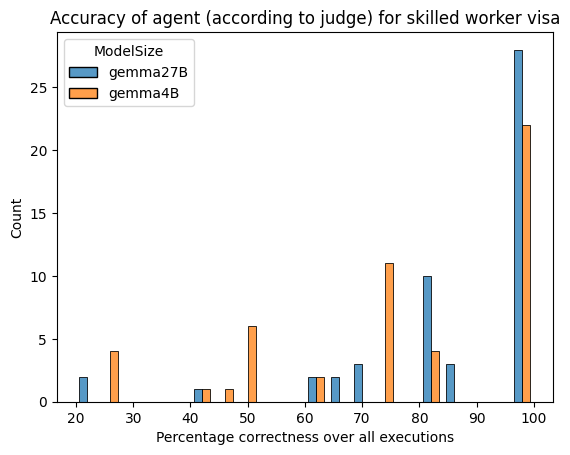

In [4]:
def get_success_rates_by_permutation(combined_df: pd.DataFrame) -> pd.DataFrame:
    df = (
        100
        * combined_df[combined_df[success_column] == True]
        .index.get_level_values(2)
        .value_counts()
        / combined_df.index.get_level_values(2).value_counts()
    )
    print(df.nsmallest(n=15))
    return df


def get_success_rates_by_permutation_model_size(combined_df: pd.DataFrame, test_cohort) -> pd.DataFrame:
    df = (
        100
        * combined_df[combined_df[success_column] == True]
        .index.droplevel(0)
        .droplevel(0)
        .value_counts()
        / combined_df.index.droplevel(0).droplevel(0).value_counts()
    )
    print(df.nsmallest(n=15))
    print(df.reset_index().set_index("permutation").value_counts())

    fig_name = "success_rates_by_permutation_model_size.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    ax = sns.histplot(
        df.reset_index(),
        x="count",
        hue="ModelSize",
        multiple="dodge",
        shrink=0.7,
        bins=20,
        common_bins=True,
    )
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")

    return df


success_rates_by_permutations = get_success_rates_by_permutation(
    combined_dfs
)
success_rates_by_permutation_model_sizes = (
    get_success_rates_by_permutation_model_size(
        combined_dfs, test_cohort
    )
)

count
 0.000000    18
 0.500000     4
 0.050000     4
 0.250000     3
-0.119048     2
 0.300000     2
-0.200000     2
-0.166667     1
-0.133333     1
-0.142857     1
-0.083333     1
 0.412698     1
-0.350000     1
 0.285714     1
 0.200000     1
 0.750000     1
 0.375000     1
 0.350000     1
-0.150000     1
-0.550000     1
 0.232143     1
 0.550000     1
-0.050000     1
Name: count, dtype: int64


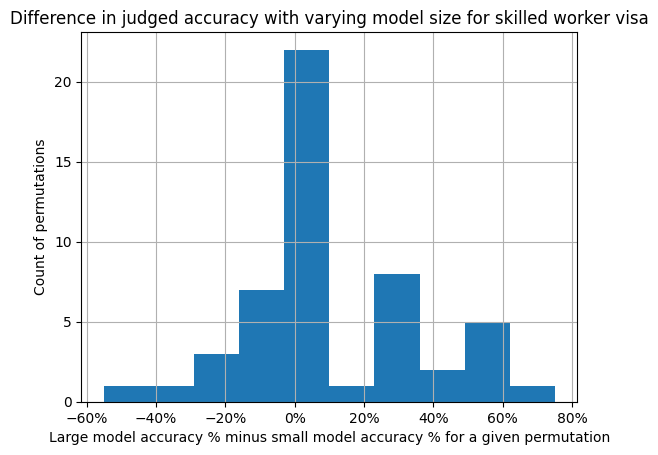

In [5]:
def get_large_model_improvements_by_permutation(
    combined_df_raw: pd.DataFrame,
    test_cohort
) -> pd.DataFrame:
    df = (
        combined_df_raw[
            (combined_df_raw[success_column] == True)
            & (combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["improved"])
        ]
        .index.get_level_values(2)
        .value_counts()
        / combined_df_raw[(combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["improved"])]
        .index.get_level_values(2)
        .value_counts()
    ) - (
        combined_df_raw[
            (combined_df_raw[success_column] == True)
            & (combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["baseline"])
        ]
        .index.get_level_values(2)
        .value_counts()
        / combined_df_raw[(combined_df_raw["ModelSize"] == model_sizes_hypothesis_mapping[test_cohort]["baseline"])]
        .index.get_level_values(2)
        .value_counts()
    )

    fig_name = "success_rates_by_permutation_model_size.improvement.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df.hist()
    ax = fig.get_axes()[0]
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(
        figure_annotations[test_cohort][fig_name]["xlabel"]
    )
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    fig.savefig(
        f"figures/{fig_name}.{test_cohort}.png"
    )
    print(df.value_counts())
    return df

large_model_improvement_by_permutations = (
    get_large_model_improvements_by_permutation(
        combined_dfs_raw, test_cohort
    )
)

In [6]:
def get_success_rates_by_eligibility(
    success_rates_by_permutation: pd.DataFrame,
    eligibility_df: pd.DataFrame,
    test_cohort,
) -> pd.DataFrame:
    fig_name = "success_rates_by_eligibility.hist"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df = eligibility_df.join(success_rates_by_permutation)
    df["eligibility_cat"] = df.apply(get_eligibility_case, axis=1)

    #  df = df.set_index(["eligible", "not_eligible"], append=True)
    #  df.hist()

    ax = sns.histplot(
        df,
        x="count",
        hue="eligibility_cat",
        multiple="dodge",
        shrink=0.7,
        bins=20,
        common_bins=True,
    )
    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100.0))

    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
    return df

#print(
#    combined_dfs_raw.value_counts(
#        [success_column, "eligible", "not_eligible"]
#    )
#)
#success_rates_by_eligibilitys = get_success_rates_by_eligibility(
#    success_rates_by_permutations,
#    eligibility_dfs,
#    test_cohort,
#)

In [7]:
def get_success_rates_by_eligibility_model_size(
    success_rates_by_permutation_model_size: pd.DataFrame,
    eligibility_df: pd.DataFrame,
    test_cohort,
) -> pd.DataFrame:
    fig_name = "success_rates_by_eligibility.modelSize"
    fig = plt.figure(f"{fig_name}_{test_cohort}")
    fig.clear()
    df = eligibility_df.join(success_rates_by_permutation_model_size)
    df["eligibility_cat"] = df.apply(get_eligibility_case, axis=1)

    df = df.reset_index().groupby(["eligibility_cat", "ModelSize"], axis=0).mean("count")

    ax = sns.heatmap(
        df.reset_index().pivot(index="ModelSize", columns="eligibility_cat", values="count"),
        annot=True,
        fmt=".1f"
    )

    ax.set_ylabel(figure_annotations[test_cohort][fig_name]["ylabel"])
    ax.set_xlabel(figure_annotations[test_cohort][fig_name]["xlabel"])
    #  ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(100.0))
    ax.set_title(
        figure_annotations[test_cohort][fig_name]["title"]
    )

    fig.savefig(f"figures/{fig_name}.{test_cohort}.png")
    return df


#success_rates_by_eligibility_model_size = get_success_rates_by_eligibility_model_size(
#    success_rates_by_permutation_model_sizes,
#    eligibility_dfs,
#    test_cohort,
#)

In [8]:
#if __name__ == "__main__":
#    main(["skilled_worker_visa"])

# **Test Execution Observations \- (Skilled Worker Visa)**

# **Executive Summary**

We tested whether a simple conversational agent could give reliable eligibility guidance for a complex service, and whether a larger model improved outcomes. Under this architecture, eligibility results were inconsistent and strongly influenced by randomness, with no meaningful improvement from increasing model size. This suggests that complex eligibility cannot be safely handled by a prompt-driven conversational agent alone; stronger structural controls are required.

# **Methodology** 

## **1\. What were we trying to answer** 

* Is there an upper limit to the complexity of eligibility criteria that an agentic system can advise on.  
* What is the effect of size of the underlying foundation model on accuracy

## **2\. What we tested (plain English)** 

Service: Skilled Worker Visa

Setup: 

* One agent-under-test, representing the agent which a user would be communicating with if this were a real service   
  * Backed by a foundation model, either small (4 billion parameters) or large (27 billion parameters)   
  * [Prompt provided to agent was simple instructions to hold a conversation with the user to determine their eligibility for the skilled worker visa](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/TechnicalHypotheses/adhoc-skilledWorkerVisa.md)  
* For the purposes of testing, a judge agent to take on the role of user, and make judgements based on the responses of the agent-under-test   
* no personal data integrations 

Scenarios: 50 scenarios devised by Gemini, by asking it to review the skilled worker visa eligibility guidance and devise scenarios describing all the permutations of that guidance it could think of, representing realistic happy/sad paths 

Task: 

* Judge agent takes on persona described by a scenario, converses with agent under test, once agent under test has given an indication of eligibility   
* The judge agent compares that with the expected eligibility outcome described in the scenario.   
* If the outcome given by the agent under test matches the expected outcome described in the scenario, and the agent under test has not given any information which the judge agent considers to be incorrect, then the judge agent marks the result as a success.   
* Otherwise, the judge agent marks the result as a failure 

## **3\. What “good” looked like** 

* Agent-under-test does not make any statements which can be considered to be inaccurate with respect to the published government guidance on child benefit eligibility   
* Agent-under-test communicates an indication of eligibility which aligns with the published government guidance on child benefit eligibility 

## **4\. What happened** 

### **Headline result** 

* The results suggest a strong influence of random chance over the results    
* For a given scenario, if we subtract the average Subtracting the average result produced 

### **Supporting Signals** 

* For a given scenario, the large model should achieve consistently better results than the small model, so long as the impact of random chance in determining the outcome is sufficiently low   
  * This is because a larger version of a model is objectively better at achieving a correct outcome for a task than a similar model of a smaller size (in parameters)  
  * It is expected that randomness will have a small role to play in defining the outcome.  
* Therefore if we run the test suite repeatedly, and average the results for a particular scenario and model size, we should see that the average performance (i.e. how often the judge agent agrees the agent under test has met the criteria for success) for a particular scenario will be higher for the large model than for the small  
* The results in the following graph should all be greater than 0  
  ![][image1]  
* The number of results less than zero is about equal to the number of results above zero  
  * This suggests a high impact of randomness on whether the agent under test will be deemed successful.  
* Furthermore the shape of the graph can be said to show similarities to what is known as a Normal Distribution, which is the distribution observed over a random variable.

## 

## **5\. What we learned** 

* The current simple architecture of one agent with a simple prompt doesn’t provide the expected consistency.  
  * Further work to apply this dataset to an improved version of the system might lead to more positive results

## **6\. How this experiment shaped what we do next** 

* No immediate impact, except to park this work for now  
* There may be value in rerunning this dataset at a later date on an improved version of the system

## **7\. Artefacts & useful links** 

* [Scenarios tested](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/manual/test_cases/skilled_worker_visa.md)   
* [Judge Prompt](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/absolutely-not-main/prompts/agents/Ancillary/EvaluationJudge.md)   
* [Agent Prompt](https://github.com/govuk-once/gds-eligibility-agentic-backend/blob/master/prompts/agents/TechnicalHypotheses/adhoc-skilledWorkerVisa.md) 

# **Appendix** 

		 			 			 			 			 			 			 		 		

## Overall Distribution of Failures over all Permutations

* Some clustering, but much less pronounced than for child benefit:

## Comparison of Rate of Occurrence of Failures Based on Model Size

![][image2]

* If we assume that the large model should be at least as good as the small model, then the average accuracy of a permutation over all large model runs minus the average accuracy of a permutation over all small model runs should be positive if the results can be considered consistent  
* The graph above shows:  
  * As many permutations where the small model is more accurate than the large model than visa versa  
  * A roughly normal distribution, which suggests that the mechanism underlying the distribution is stochastic (i.e. random)  
* This suggests that the current approach is unable to yield consistent results regardless of model size

	

[image1]: <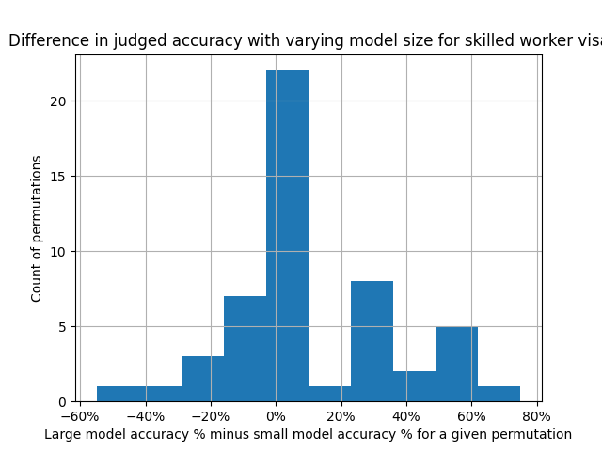>

[image2]: <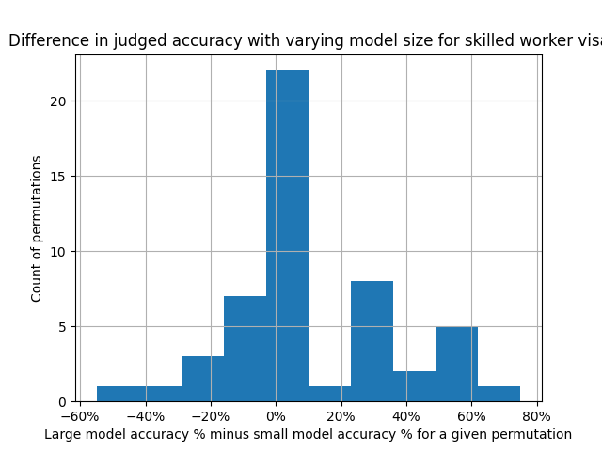>